# Trees and Rent in NYC
### an exploration into the relationship between trees and rent prices in NYC neighborhoods
### Author: Tan Mahmud

## Step 1: Data Preprocessing

### Rent Data:

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt 
import seaborn as sns
plt.style.use('ggplot')
from scipy import stats


rent_df = pd.read_csv('data/medianRent.csv')
rent_df.head()

,areaName,Borough,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,...,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03
0,All Downtown,Manhattan,submarket,2995.0,2950.0,2900.0,2975.0,2995.0,3000.0,3000.0,...,4670.0,4500.0,4500.0,4550.0,4500.0,4500.0,4600.0,4730.0,4750.0,4705.0
1,All Midtown,Manhattan,submarket,2800.0,2800.0,2850.0,2895.0,2900.0,2970.0,3000.0,...,4490.0,4400.0,4391.0,4329.0,4210.0,4173.0,4210.0,4300.0,4308.0,4395.0
2,All Upper East Side,Manhattan,submarket,2350.0,2300.0,2350.0,2470.0,2500.0,2500.0,2500.0,...,3650.0,3500.0,3500.0,3500.0,3550.0,3600.0,3585.0,3600.0,3795.0,3695.0
3,All Upper Manhattan,Manhattan,submarket,1500.0,1516.0,1545.0,1516.0,1550.0,1575.0,1550.0,...,2495.0,2450.0,2475.0,2450.0,2400.0,2400.0,2400.0,2450.0,2495.0,2500.0
4,All Upper West Side,Manhattan,submarket,2600.0,2565.0,2495.0,2500.0,2500.0,2600.0,2600.0,...,4000.0,4100.0,4100.0,4124.0,4095.0,4000.0,3995.0,4000.0,4198.0,4200.0


In [2]:
#keep only rows where area type is a neighborhood
rent_df = rent_df[(rent_df['areaType'] == 'neighborhood')]
rent_df = rent_df.drop(columns = ['areaType'])
# drop columns for rent information not in 2015, the year of the tree census
columns_to_keep = [col for col in rent_df.columns if (col[0] != '2' or col.startswith('2015'))]
rent_df = rent_df[columns_to_keep]

#add a new column that finds the yearly average for median rent for each neighborhood
month_cols = [col for col in rent_df.columns if col.startswith('2015')]
rent_df['averageRent2015'] = rent_df[month_cols].mean(axis=1)

#drop month_cols, and then drop null values
rent_df = rent_df.drop(columns=month_cols)
rent_df = rent_df.dropna()
rent_df.head()

,areaName,Borough,averageRent2015
5,Astoria,Queens,1896.916667
8,Battery Park City,Manhattan,3687.416667
9,Bay Ridge,Brooklyn,1608.250000
11,Bayside,Queens,1400.000000
12,Bedford Park,Bronx,1354.250000


#### this cleaning process signficiantly decreased our datset, going from 198 rows to 110. However, it still encapsulates a diverse representation of each borough

In [3]:
borough_counts = rent_df['Borough'].value_counts()
print(borough_counts)

Brooklyn     38
Manhattan    30
Queens       22
Bronx        20
Name: Borough, dtype: int64


### Tree Data:

In [4]:
tree_df = pd.read_csv('data/treeCensus.csv')
tree_df.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp
0,08/27/2015,180683,348711,POINT (-73.84421521958048 40.723091773924274),3,0,OnCurb,Alive,Fair,Acer rubrum,...,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1.027431e+06,202756.768749
1,09/03/2015,200540,315986,POINT (-73.81867945834878 40.79411066708779),21,0,OnCurb,Alive,Fair,Quercus palustris,...,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1.034456e+06,228644.837379
2,09/05/2015,204026,218365,POINT (-73.93660770459083 40.717580740099116),3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1.001823e+06,200716.891267
3,09/05/2015,204337,217969,POINT (-73.93445615919741 40.713537494833226),10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1.002420e+06,199244.253136
4,08/30/2015,189565,223043,POINT (-73.97597938483258 40.66677775537875),21,0,OnCurb,Alive,Good,Tilia americana,...,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,9.909138e+05,182202.425999


In [5]:
# drop Staten Island from tree_df, as Staten Island was not represented in StreetEasy
tree_df = tree_df[(tree_df['boroname'] != 'Staten Island')]

# keep relevant columns of tree_df, drop NA values
tree_df = tree_df[['health', 'spc_latin', 'spc_common', 'sidewalk', 'problems', 'boroname', 'nta_name']]
tree_df = tree_df.dropna()

tree_df.head()

,health,spc_latin,spc_common,sidewalk,problems,boroname,nta_name
0,Fair,Acer rubrum,red maple,NoDamage,None,Queens,Forest Hills
1,Fair,Quercus palustris,pin oak,Damage,Stones,Queens,Whitestone
2,Good,Gleditsia triacanthos var. inermis,honeylocust,Damage,None,Brooklyn,East Williamsburg
3,Good,Gleditsia triacanthos var. inermis,honeylocust,Damage,Stones,Brooklyn,East Williamsburg
4,Good,Tilia americana,American linden,Damage,Stones,Brooklyn,Park Slope-Gowanus


### Standardizing neighborhood names across both datasets

I noticed that in the majority of cases, `rent_df` used a shortened version of the neighborhood names in `tree_df`. For instance, what is 'Battery Park City-Lower Manhattan' in `tree_df`, is 'Battery Park City' in rent_df. 'Bedford Park-Fordam North' is 'Bedford Park', etc. This makes sense as Streeteasy is meant for marketing and the tree census is from a government source. So I applied a simple function to change the longer names in `tree_df` to the shorter names in `rent_df` to make joins easier later.  

In [6]:
def new_neighborhoodName(name, neighborhoodList):
    if name == 'Bedford': 
        return 'Bedford-Stuyvesant'
    if name == 'Gramercy':
        return 'Gramercy Park'
    if name == 'Manhattanville': 
        return 'West Harlem'
    if name == 'North Corona': 
        return name
    if 'East Midtown' in name: 
        return 'Midtown East'
    for neighborhood in neighborhoodList:
        if neighborhood in name:
            return neighborhood
    return name

tree_df['nta_name'] = tree_df['nta_name'].apply(lambda x: new_neighborhoodName(x, rent_df['areaName']))

### Group tree data by neighborhood

In [7]:
nb_trees = tree_df.groupby('nta_name').size().reset_index(name='total_trees')
most_popular_tree_species = tree_df.groupby('nta_name')['spc_common'].agg(lambda x: x.mode().iloc[0]).reset_index(name='most_popular')
percent_good_health = tree_df.groupby('nta_name')['health'].agg(lambda x: (x == 'Good').mean()).reset_index(name='percent_good_health')
percent_fair_health = tree_df.groupby('nta_name')['health'].agg(lambda x: (x == 'Fair').mean()).reset_index(name='percent_fair_health')
percent_poor_health = tree_df.groupby('nta_name')['health'].agg(lambda x: (x == 'Poor').mean()).reset_index(name='percent_poor_health')
nb_trees_stats = tree_df.groupby('nta_name').agg({
    'sidewalk': lambda x: (x == 'Damage').mean(),  # Percentage of trees with sidewalk damage
    'problems': lambda x: (x != 'None').mean()  # Percentage of trees with problems
})

nb_trees = nb_trees.merge(most_popular_tree_species, on='nta_name')
nb_trees = nb_trees.merge(nb_trees_stats, on='nta_name')
nb_trees = nb_trees.merge(percent_good_health, on='nta_name')
nb_trees = nb_trees.merge(percent_fair_health, on='nta_name')
nb_trees = nb_trees.merge(percent_poor_health, on='nta_name')

nb_trees = nb_trees.rename(columns={
    'sidewalk': 'percentage_sidewalk_damage',
    'problems': 'percentage_problems'
})

nb_trees.head()

,nta_name,total_trees,most_popular,percentage_sidewalk_damage,percentage_problems,percent_good_health,percent_fair_health,percent_poor_health
0,Allerton-Pelham Gardens,3598,London planetree,0.283491,0.441356,0.826292,0.135075,0.038633
1,Astoria,5459,pin oak,0.361971,0.447151,0.834219,0.129694,0.036087
2,Auburndale,5119,London planetree,0.205314,0.260793,0.862668,0.101192,0.036140
3,Baisley Park,4552,London planetree,0.252856,0.277021,0.865993,0.105668,0.028339
4,Bath Beach,1744,London planetree,0.404243,0.437500,0.865826,0.110665,0.023509


### Group Tree Data by species
It might be interesting to check later on where unique trees are found

In [8]:
species_tree = tree_df.groupby('spc_common').size().reset_index(name='total')
favorite_neighborhood = tree_df.groupby('spc_common')['nta_name'].agg(lambda x: x.mode().iloc[0]).reset_index(name='favorite_neighborhood')
species_tree = species_tree.merge(favorite_neighborhood, on='spc_common')
species_tree.head() 

,spc_common,total,favorite_neighborhood
0,'Schubert' chokecherry,4059,East New York
1,American beech,224,Greenpoint
2,American elm,7465,Crown Heights
3,American hophornbeam,930,East New York
4,American hornbeam,1248,East New York


### Join Datasets
Now that we have grouped `tree_df` by neighborhood name, we are going to perform an inner join with `rent_df` as we only want to work with neighborhoods where we have both tree and rent data. 

In [9]:
trees_and_rent = pd.merge(rent_df, nb_trees, left_on='areaName', right_on='nta_name', how='inner')

# drop redundant col, rename
trees_and_rent.drop(columns=['nta_name'], inplace=True)
trees_and_rent.rename(columns={'areaName': 'neighborhood'}, inplace=True)

print(f"There are {trees_and_rent.shape[0]} rows in this dataset")
trees_and_rent.head()

There are 87 rows in this dataset


,neighborhood,Borough,averageRent2015,total_trees,most_popular,percentage_sidewalk_damage,percentage_problems,percent_good_health,percent_fair_health,percent_poor_health
0,Astoria,Queens,1896.916667,5459,pin oak,0.361971,0.447151,0.834219,0.129694,0.036087
1,Battery Park City,Manhattan,3687.416667,1264,honeylocust,0.034810,0.127373,0.802215,0.154272,0.043513
2,Bay Ridge,Brooklyn,1608.250000,6722,London planetree,0.267629,0.357483,0.861648,0.109491,0.028860
3,Bayside,Queens,1400.000000,9386,London planetree,0.278287,0.366397,0.825911,0.138185,0.035905
4,Bedford Park,Bronx,1354.250000,1721,honeylocust,0.365485,0.390471,0.797211,0.158048,0.044741


## Step 2: Exploratory Data Analysis
Going into exploratory data analysis, I am looking for any strong correlations between rent and different tree data. I also must consider the fact that certain boroughs naturally have better suited environments for trees than others, so it is crucial I also group by borough in my exploration. 

In [10]:
# Seperate data by borough
queens_data = trees_and_rent[trees_and_rent['Borough'] == 'Queens']
brooklyn_data = trees_and_rent[trees_and_rent['Borough'] == 'Brooklyn']
bronx_data = trees_and_rent[trees_and_rent['Borough'] == 'Bronx']
manhattan_data = trees_and_rent[trees_and_rent['Borough'] == 'Manhattan']

### Feature exploration: total trees

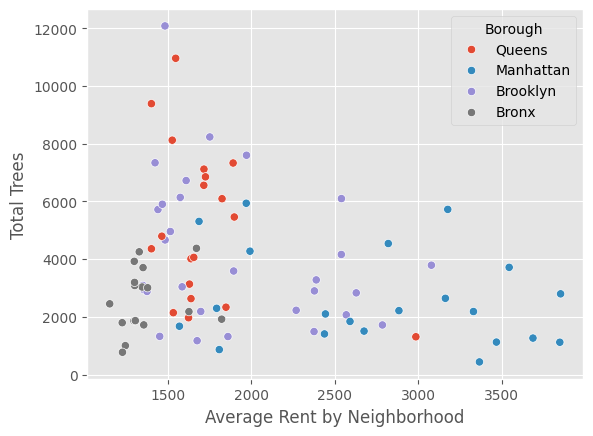

In [11]:
sns.scatterplot(x='averageRent2015', y='total_trees', data=trees_and_rent, hue='Borough')
plt.xlabel('Average Rent by Neighborhood')
plt.ylabel('Total Trees')
plt.legend(title='Borough')
plt.show()

At first glance, this graph seems to indicate that across boroughs (with the exception of the Bronx), there is a negative relationship between rent price and total trees. 

In [12]:
corr_coef, p_value = stats.pearsonr(trees_and_rent['averageRent2015'], trees_and_rent['total_trees'])
print("Pearson correlation coefficient between rent and total trees:", corr_coef)
print("P-value:", p_value)

Pearson correlation coefficient between rent and total trees: -0.2464286293276804
P-value: 0.021397638287343645


**`p-value` is less than 0.05, which seems to indicate that the `correlation` between average rent is statistically signficant.** However, we must consider the fact that Manhattan is signficantly more expensive than the other boroughs, and does not have a lot of land for trees to grow. For this reason, we will now look at each borough individually. 

In [13]:
def get_p_value(boroughs, col): 
    for borough in boroughs: 
        borough_data = globals()[f'{borough}_data']
        corr_coef, p_value = stats.pearsonr(borough_data['averageRent2015'], borough_data[col])
        print(f"Pearson correlation coefficient between rent and {col} in {borough}:", corr_coef)
        print(f"P-value for {borough}:", p_value)

get_p_value(['queens', 'brooklyn', 'manhattan', 'bronx'], 'total_trees')

Pearson correlation coefficient between rent and total_trees in queens: -0.35481379479767505
P-value for queens: 0.13606704306504536
Pearson correlation coefficient between rent and total_trees in brooklyn: -0.2880411640944643
P-value for brooklyn: 0.12971146220620913
Pearson correlation coefficient between rent and total_trees in manhattan: -0.24130853033434996
P-value for manhattan: 0.2919856111629124
Pearson correlation coefficient between rent and total_trees in bronx: 0.19934837460575153
P-value for bronx: 0.42774638931297926


**for each `borough`the `p-value` is greater than 0.05, indicating no statistical signficance in the `correlation` between rent and total trees.** The p-value was most likely under .05 for `trees_and_rent`, our dataset encompassing all of NYC, because it is a larger dataset and because the `Manhattan` values were creating a skew. There exists a weak `correlation`, with the strongest one being in `Queens` with `correlation` = -.35, which is still only moderate at best. 

### other quantitative feature exploration 
I will now check the correlation coefficient between rent and the other features 

#### percentage of trees causing sidewalk damage:

##### overall: 

In [14]:
corr_coef, p_value = stats.pearsonr(trees_and_rent['averageRent2015'], trees_and_rent['percentage_sidewalk_damage'])
print("Pearson correlation coefficient between rent and sidewalk damage:", corr_coef)
print("P-value:", p_value)

Pearson correlation coefficient between rent and sidewalk damage: -0.3106076537653048
P-value: 0.003411042770961852


##### by borough: 

In [15]:
get_p_value(['queens', 'brooklyn', 'manhattan', 'bronx'], 'percentage_sidewalk_damage')

Pearson correlation coefficient between rent and percentage_sidewalk_damage in queens: 0.32854797841229216
P-value for queens: 0.1696382762659446
Pearson correlation coefficient between rent and percentage_sidewalk_damage in brooklyn: -0.009103415404243713
P-value for brooklyn: 0.9626185596037063
Pearson correlation coefficient between rent and percentage_sidewalk_damage in manhattan: -0.14202573839563393
P-value for manhattan: 0.5391383711922084
Pearson correlation coefficient between rent and percentage_sidewalk_damage in bronx: -0.10441383768721768
P-value for bronx: 0.6801065002908072


#### percentage of trees experiencing problems (roots, stones, metal grates, wire/rope)
##### overall: 

In [16]:
corr_coef, p_value = stats.pearsonr(trees_and_rent['averageRent2015'], trees_and_rent['percentage_problems'])
print("Pearson correlation coefficient between rent and tree problems:", corr_coef)
print("P-value:", p_value)

Pearson correlation coefficient between rent and tree problems: 0.07127639715024994
P-value: 0.5117975320692324


##### by borough: 

In [17]:
get_p_value(['queens', 'brooklyn', 'manhattan', 'bronx'], 'percentage_problems')

Pearson correlation coefficient between rent and percentage_problems in queens: 0.24748896712137503
P-value for queens: 0.3069953861054164
Pearson correlation coefficient between rent and percentage_problems in brooklyn: 0.36688310013490383
P-value for brooklyn: 0.05026547520979785
Pearson correlation coefficient between rent and percentage_problems in manhattan: -0.020550032999196763
P-value for manhattan: 0.9295472172509659
Pearson correlation coefficient between rent and percentage_problems in bronx: 0.20140127495677818
P-value for bronx: 0.42290456222826384


*above, there seems to indicate a possible statistical signficance between rent and percentage of trees facing problems in Brooklyn neighborhoods. Surprisingly, it is a positive relationship* 

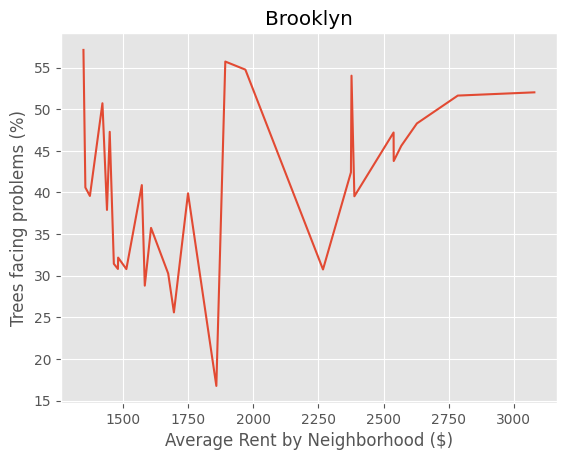

In [18]:
sns.lineplot(x='averageRent2015', y=brooklyn_data['percentage_problems'] * 100, data=brooklyn_data)
plt.xlabel('Average Rent by Neighborhood ($)')
plt.ylabel('Trees facing problems (%)')
plt.title("Brooklyn")
plt.show()

*with only a correlation coefficient of .37, this graph shows a weak positive relationship* 

#### percentage of trees in good health
##### overall: 

In [19]:
corr_coef, p_value = stats.pearsonr(trees_and_rent['averageRent2015'], trees_and_rent['percent_good_health'])
print("Pearson correlation coefficient between rent and percentage of trees in good health", corr_coef)
print("P-value:", p_value)

Pearson correlation coefficient between rent and percentage of trees in good health -0.215312053130998
P-value: 0.04519805975526781


##### by borough: 

In [20]:
get_p_value(['queens', 'brooklyn', 'manhattan', 'bronx'], 'percent_good_health')

Pearson correlation coefficient between rent and percent_good_health in queens: -0.08556312261007712
P-value for queens: 0.7276293920747625
Pearson correlation coefficient between rent and percent_good_health in brooklyn: -0.18124590285720846
P-value for brooklyn: 0.34674041464320626
Pearson correlation coefficient between rent and percent_good_health in manhattan: 0.22424049777747457
P-value for manhattan: 0.32847208537890576
Pearson correlation coefficient between rent and percent_good_health in bronx: 0.0633361237104515
P-value for bronx: 0.8028415525241224


#### percentage of trees in poor health 
##### overall: 

In [21]:
corr_coef, p_value = stats.pearsonr(trees_and_rent['averageRent2015'], trees_and_rent['percent_poor_health'])
print("Pearson correlation coefficient between rent and percentage of trees in poor health", corr_coef)
print("P-value:", p_value)

Pearson correlation coefficient between rent and percentage of trees in poor health 0.19541459332209196
P-value: 0.06969724885851708


##### by borough: 

In [22]:
get_p_value(['queens', 'brooklyn', 'manhattan', 'bronx'], 'percent_poor_health')

Pearson correlation coefficient between rent and percent_poor_health in queens: -0.005503462803841215
P-value for queens: 0.9821604186624683
Pearson correlation coefficient between rent and percent_poor_health in brooklyn: 0.027215791897356744
P-value for brooklyn: 0.8885490926955524
Pearson correlation coefficient between rent and percent_poor_health in manhattan: -0.33014693781781584
P-value for manhattan: 0.14384181168335713
Pearson correlation coefficient between rent and percent_poor_health in bronx: -0.12607458785973896
P-value for bronx: 0.6181417326020406


### Finding from quantitative feature exploration: 
When it came to rent prices by neighborhood, the null hypothesis was proven in its relationship to every other feature for each of the boroughs. The only case where `p-value` was significant (<= 0.05) was when looking at the overall NYC dataset, however that is unreliable given the distinct environments of the boroughs. 

#### categorical feature exploration: 
I will now try to find any correlations between tree species and rent, such as whether or not a certain tree species is more common in neighborhoods with higher rent, what neighborhoods see the highest tree diversity, and where rarer tree species are located.

##### rare tree species: 

In [23]:
# sorting dataframe grouped by tree species by rarest to most common
sorted_species = species_tree.sort_values(by='total', ascending=True).reset_index(drop=True)

#add a column for the percentage of all trees in NYC this tree makes up 
sorted_species['percentage'] = sorted_species['total'] / tree_df.shape[0]

median_percentage = sorted_species['percentage'].median()
print('Median percentage of tree make up by species:', f'{median_percentage * 100}%')
percentile_25 = sorted_species['percentage'].quantile(0.25)
print('25th percentile of tree make up by species:', f'{percentile_25 * 100}%') 

Median percentage of tree make up by species: 0.09469748556839373%
25th percentile of tree make up by species: 0.02810054821037187%


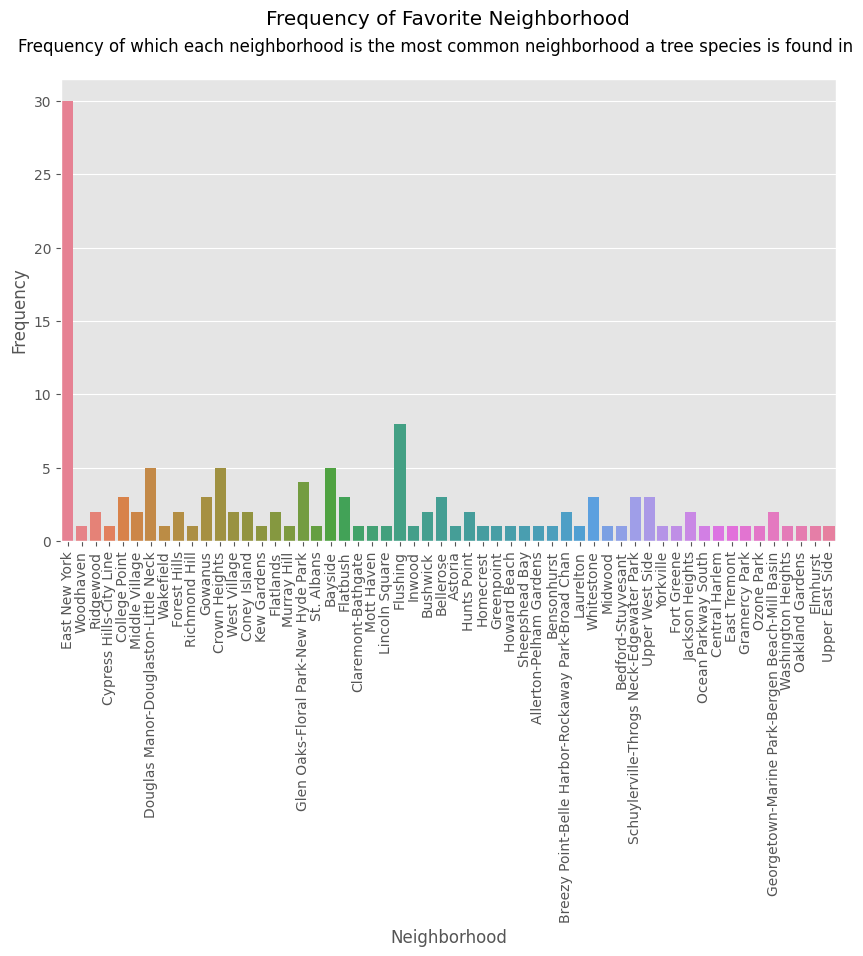

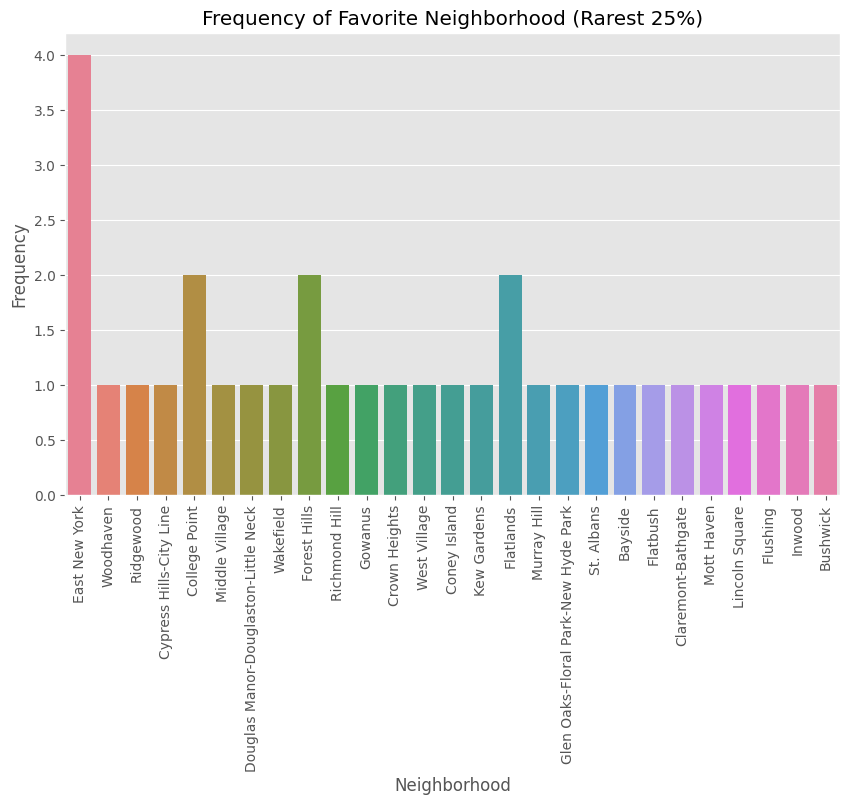

In [24]:
# df with only top 25% rarest tree species 
rarest_25_percent = sorted_species[sorted_species['percentage'] <= percentile_25]

plt.figure(figsize=(10, 6))

sns.countplot(x='favorite_neighborhood', data=sorted_species, hue='favorite_neighborhood', legend=False)

plt.xticks(rotation=90)

plt.title('Frequency of Favorite Neighborhood', y=1.1)
plt.suptitle('Frequency of which each neighborhood is the most common neighborhood a tree species is found in', y=.95)
plt.xlabel('Neighborhood')
plt.ylabel('Frequency')

plt.show()

plt.figure(figsize=(10, 6))

sns.countplot(x='favorite_neighborhood', data=rarest_25_percent, hue='favorite_neighborhood', legend=False)


plt.xticks(rotation=90)

plt.title('Frequency of Favorite Neighborhood (Rarest 25%)')
plt.xlabel('Neighborhood')
plt.ylabel('Frequency')


plt.show()

The graphs above do not seem to indicate that rarer tree species are gravitating toward any specific neighborhoods. While East New York is the most common favorite neighborhood of tree species, this is unsurprising as East New York has the most trees of any neighborhood. 

##### most popular tree species and average rent

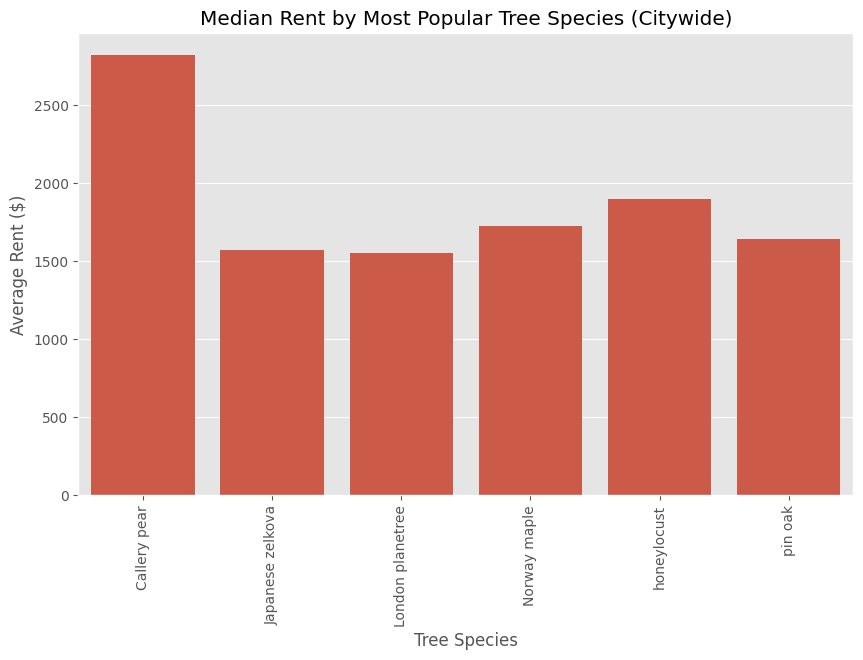

In [25]:
most_popular = trees_and_rent.groupby('most_popular')['averageRent2015'].median().reset_index()



plt.figure(figsize=(10, 6))


sns.barplot(x='most_popular', y='averageRent2015', data=most_popular)

plt.xticks(rotation=90)

plt.title('Median Rent by Most Popular Tree Species (Citywide)')
plt.xlabel('Tree Species')
plt.ylabel('Average Rent ($)')


plt.show()

The graph above, highlighting tree species and the median of rent of the neighborhoods in which they are the most popular, may indicate that callery pear trees are found in neighborhoods with higher rent, however that could just be because it is a common tree species in Manhattan. For good measure, I will now do this same calculation by borough: 

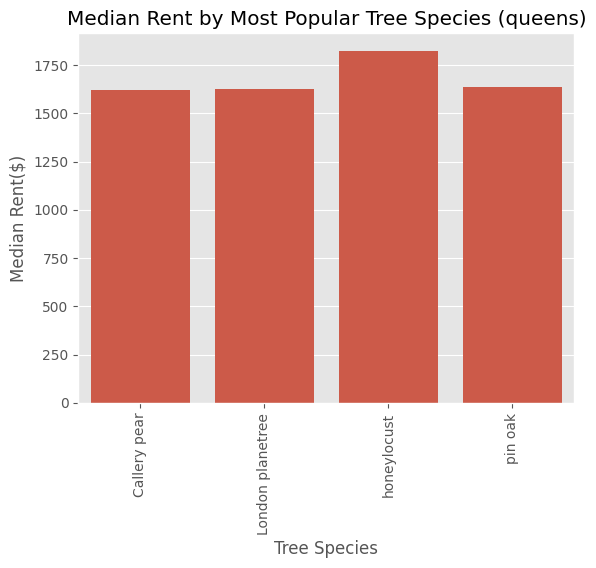

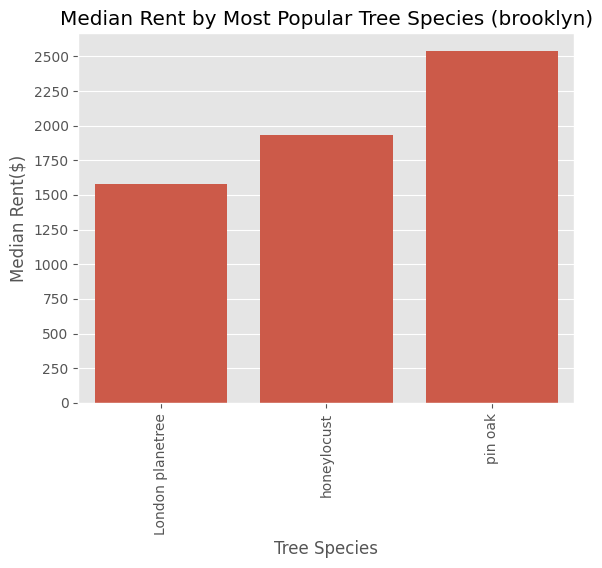

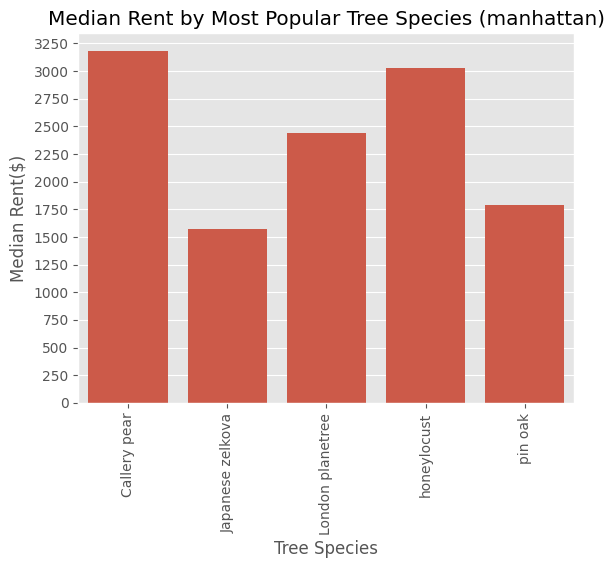

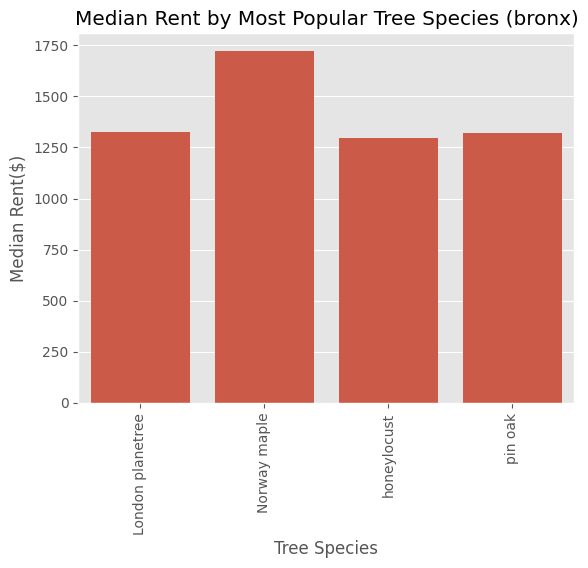

In [26]:
def plot_by_borough(boroughs): 
    for borough in boroughs: 
        borough_data = globals()[f'{borough}_data']
        most_popular_data = borough_data.groupby('most_popular')['averageRent2015'].median().reset_index()
        sns.barplot(x='most_popular', y='averageRent2015', data=most_popular_data)
        plt.xticks(rotation=90)
        max_rent = most_popular_data['averageRent2015'].max()
        y_ticks = np.arange(0, max_rent + 100, 250) # make incrementation between ticks on y-axis uniform
        plt.yticks(y_ticks)
        plt.title(f'Median Rent by Most Popular Tree Species ({borough})')
        plt.xlabel('Tree Species')
        plt.ylabel('Median Rent($)')       
        plt.show()
        
plot_by_borough(['queens', 'brooklyn', 'manhattan', 'bronx'])
    

##### initial understanding: 
- in `Queens` there does not seem to be a strong relationship between the average rent in neighborhoods where a certain tree is the most common tree species.
- in `Brooklyn` `pin oak` trees are found in neighborhoods with higher rent.
- in `Manhattan`, `callery pear` trees are found in neighborhoods with higher rent and the `japanese zelkova` is found in neighborhoods with lower rent.
- in `Bronx`, `norway maple` trees are found in neighborhoods with higher rent.

**however, this may only be true because of outliers. which is what I'll explore right now** 

In [27]:
def get_count(borough, tree):
    borough_data = globals()[f'{borough}_data']
    tree_count = borough_data[borough_data['most_popular'] == tree].shape[0]
    neighborhoods = list(borough_data['neighborhood'][borough_data['most_popular'] == tree])
    print(f'{tree} was found in {tree_count} {borough} neighborhoods: {", ".join(neighborhoods)}')

get_count('brooklyn', 'pin oak')
get_count('manhattan', 'Japanese zelkova') 
get_count('manhattan', 'Callery pear')
get_count('bronx', 'Norway maple') 

pin oak was found in 1 brooklyn neighborhoods: Gowanus
Japanese zelkova was found in 1 manhattan neighborhoods: Inwood
Callery pear was found in 2 manhattan neighborhoods: Upper East Side, West Village
Norway maple was found in 2 bronx neighborhoods: Pelham Parkway, Riverdale


**the above confirms that outliers were the reason the graphs displayed strong relationships between rent in neighborhoods and the most common tree species found in those neighborhoods** 

## Step 3: Summary of Findings 

I have failed to reject the null hypothesis when it comes to the relationship between rent and trees in NYC neighborhoods. This was true when exploring data on total trees, the percentage of trees causing sidewalk damages, the percentage of trees with issues (roots, stones, wire/rope, metal grate, etc.), the health of the trees (good, fair, poor) and tree species. 

While there was a minor `correlation` between total trees and rent in citywide data (-0.2464) and a `p-value` less than .05 (0.0214) which would indicate statistical signficance, it became clear this was due to a skew caused by Manhattan data, a borough with high average rent and a lower tree count given its urban landscape. When examining the data by individual boroughs, even boroughs with a higher `correlation` had a `p-value` much greater than .05, indicating statistical insignificance.

Additionally, while one might assume that the more expensive a neighborhood is to live in, the less problems those trees will have, every borough but `Manhattan` had a `positive correlation` between the rent and percentage of trees with problematic conditions.  The strongest relationship was in `Brooklyn`, where `correlation coefficient = .367` and `p-value = .05`, which is on the border for the threshold of statistical significance. 

When looking at categorical data like tree species, while a first glance at median rent of popular tree species by the neighborhoods in which that species is most popular indicates a strong relationship, this was proven to be caused by outliers.